<a href="https://colab.research.google.com/github/pranavsouri/LSTM/blob/main/Anomaly_Detection_Time_Series_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Anomaly Detection in Time Series with Keras


## Task 1: Import Libraries

In [1074]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

x_axis = 'TEST_PERIOD_FORMATTED'
y_axis = 'ATT_TP_DL_MV'
percent = 0.8
file_name = 'amCharts.csv'

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.2


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [1075]:
data = pd.read_csv(file_name)
df = pd.DataFrame()
df[x_axis] = pd.to_datetime(data[x_axis])
df[y_axis] = data[y_axis]
df = df.dropna()

df.head()

,TEST_PERIOD_FORMATTED,ATT_TP_DL_MV
0,2019-07-02,38.88
1,2019-07-03,38.61
2,2019-07-04,38.41
3,2019-07-05,36.79
4,2019-07-06,38.89


In [1076]:
df.shape

(485, 2)

In [1077]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.TEST_PERIOD_FORMATTED, y=df.ATT_TP_DL_MV,
                    mode='lines',
                    name=y_axis))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [1078]:
train_size = int(len(df) * percent)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(436, 2) (49, 2)


In [1079]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[[y_axis]])

train[y_axis] = scaler.transform(train[[y_axis]])
test[y_axis] = scaler.transform(test[[y_axis]])

## Task 4: Create Training and Test Splits

In [1080]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [1081]:
time_steps = 30

x_train, y_train = create_dataset(train[[y_axis]], train.ATT_TP_DL_MV, time_steps)
x_test, y_test = create_dataset(test[[y_axis]], test.ATT_TP_DL_MV, time_steps)

print(x_train.shape)

(406, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [1082]:
timesteps = x_train.shape[1]
num_features = x_train.shape[2]

In [1083]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_98 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_98 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_49 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_99 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_99 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_49 (TimeDi  (None, 30, 1)            129       
 stributed)                                          

## Task 6: Train the Autoencoder

In [1084]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
12/12 [==============================] - 4s 75ms/step - loss: 0.4798 - val_loss: 0.4383
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 0.4408 - val_loss: 0.7810
Epoch 3/100
12/12 [==============================] - 0s 11ms/step - loss: 0.3806 - val_loss: 0.3810
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2676 - val_loss: 0.3926
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2667 - val_loss: 0.3667
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2664 - val_loss: 0.4360
Epoch 7/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2777 - val_loss: 0.3641
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3216 - val_loss: 0.4256
Epoch 9/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3987 - val_loss: 0.4066
Epoch 10/100
12/12 [==============================] - 0s 11ms/step - loss: 0.3576 - val_loss: 0.5817

## Task 7: Plot Metrics and Evaluate the Model

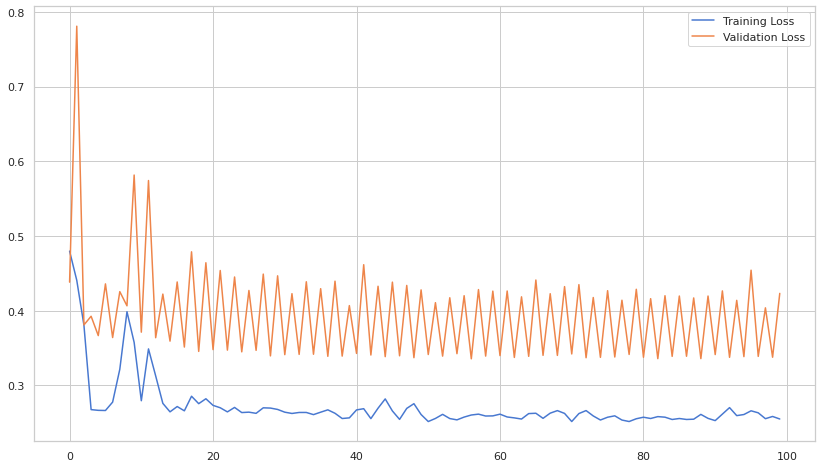

In [1085]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [1086]:
x_train_pred = model.predict(x_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(x_train_pred - x_train), axis=1), columns=['Error'])

In [1087]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 23ms/step - loss: 1.6420


1.6419765949249268

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



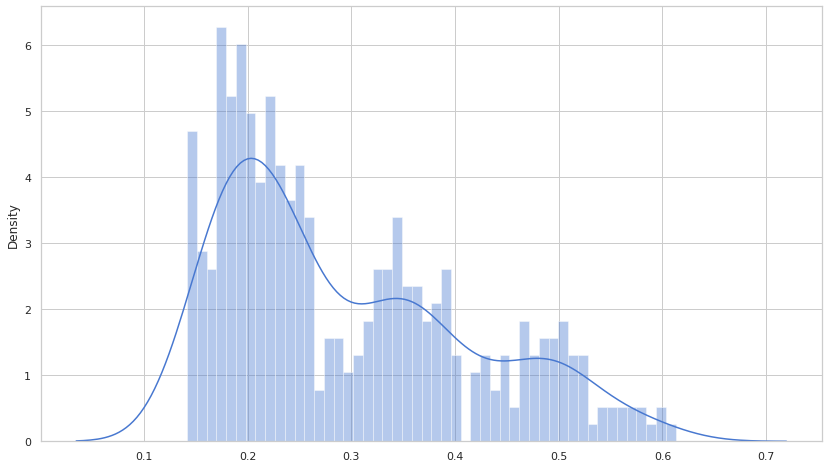

In [1088]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [1089]:
x_test_pred = model.predict(x_test)

test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



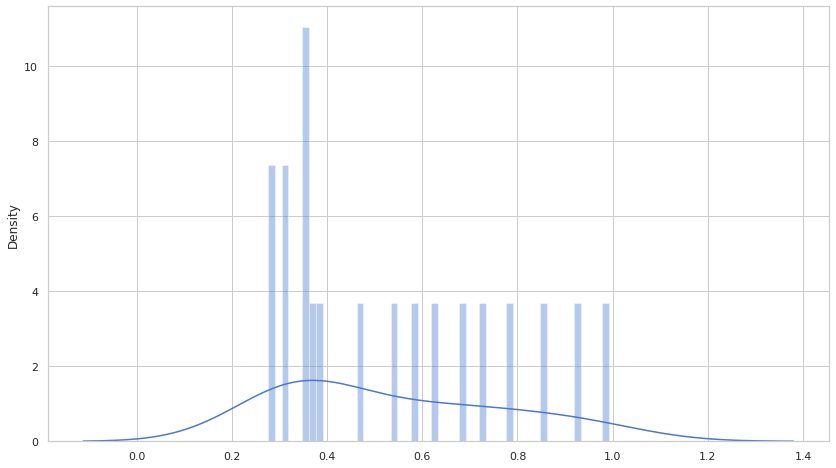

In [1090]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [1091]:
THRESHOLD = float(train_mae_loss.max())

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df[y_axis] = test[time_steps:].ATT_TP_DL_MV

In [1092]:
THRESHOLD

0.6125947428350965

In [1093]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].TEST_PERIOD_FORMATTED, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].TEST_PERIOD_FORMATTED, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [1094]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,TEST_PERIOD_FORMATTED,ATT_TP_DL_MV,loss,threshold,anomaly
485,2020-10-29,2.984141,0.632391,0.612595,True
486,2020-10-30,3.723594,0.681336,0.612595,True
487,2020-10-31,4.050785,0.728586,0.612595,True
488,2020-11-01,3.919909,0.789456,0.612595,True
489,2020-11-02,3.832658,0.860794,0.612595,True


In [1095]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].TEST_PERIOD_FORMATTED, y=test[time_steps:].ATT_TP_DL_MV,
                    mode='lines',
                    name=y_axis))
fig.add_trace(go.Scatter(x=anomalies.TEST_PERIOD_FORMATTED, y=anomalies.ATT_TP_DL_MV,
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()